In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.nn import init
from PIL import Image
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import math

# Load Data

In [2]:
def LoadData(path_to_train, path_to_test, classes=None, num_workers=2, batch_size=32, valid_size = 0.2):
    
  
    # Transformations to the image, edit as need be
    transform = transforms.Compose([transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(path_to_train, transform=transform)
    print("Successfully Loaded Training Set.")

    test_dataset = datasets.ImageFolder(path_to_test, transform=transform)
    print("Successfully Loaded Test Set.")

    
    # obtain training indices that will be used for validation
    num_train = len(train_dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                               sampler=valid_sampler, num_workers=num_workers)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, 
        num_workers=num_workers, shuffle=True)
    if classes != None:
        print("Number of Classes:", len(classes))
    return train_loader, valid_loader, test_loader, classes

In [3]:
train_loader, valid_loader,test_loader, classes = LoadData(path_to_train='/projectnb/dl523/projects/GAN_Detector/progan_train/horse/',path_to_test='/projectnb/dl523/projects/GAN_Detector/CNN_synth_testset/progan/horse/',
                                                                       classes=['Real','Fake'],num_workers=2, batch_size=32, valid_size = 0.3)

Successfully Loaded Training Set.
Successfully Loaded Test Set.
Number of Classes: 2


(32, 3, 256, 256)


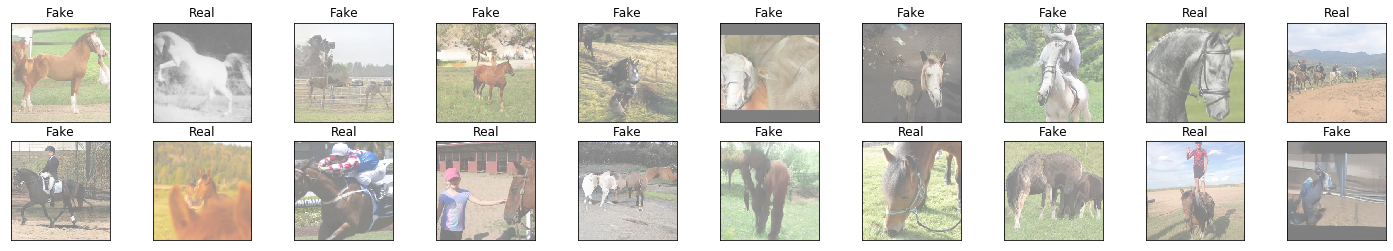

In [4]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize if you added normalization in the transformation step
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [5]:

for a,b in train_loader:
    print(b.size())
    break

torch.Size([32])


# Model

In [6]:
#  Model implementation from https://github.com/tstandley/Xception-PyTorch

class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x



class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()

        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)

        self.fc = nn.Linear(2048, num_classes)



        #------- init weights --------
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #-----------------------------





    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)

        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



def xception(pretrained=False, num_classes=2):
    """
    Construct Xception.
    """

    model = Xception(num_classes=2)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['xception']))
    return model

In [7]:
model = xception(num_classes=2)
model = nn.DataParallel(model)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-6)

In [9]:
train_on_gpu = True

In [ ]:
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss
training_vis = []
valid_vis = []

for epoch in range(1, n_epochs+1):
    print("Epoch {} start".format(epoch))
    train_loss = 0.0
    valid_loss = 0.0
    
    # train
    model.train()
    print("train ...")
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        # forward
        output = model(data)
        #print("backward ...")
        # calculate loss
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

          
    # validate the model
    model.eval()
    print("eval ... ")
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        
        # forward
        output = model(data)
        # calculate loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    training_vis.append(train_loss)
    valid_vis.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\nValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'Xception.pt')
        valid_loss_min = valid_loss

Epoch 1 start
train ...
eval ... 
Epoch: 1 	Training Loss: 0.484755 	Validation Loss: 0.207054

Validation loss decreased (inf --> 0.207054).  Saving model ...
Epoch 2 start
train ...
eval ... 
Epoch: 2 	Training Loss: 0.481761 	Validation Loss: 0.206440

Validation loss decreased (0.207054 --> 0.206440).  Saving model ...
Epoch 3 start
train ...
eval ... 
Epoch: 3 	Training Loss: 0.478411 	Validation Loss: 0.206314

Validation loss decreased (0.206440 --> 0.206314).  Saving model ...
Epoch 4 start
train ...
eval ... 
Epoch: 4 	Training Loss: 0.473558 	Validation Loss: 0.204069

Validation loss decreased (0.206314 --> 0.204069).  Saving model ...
Epoch 5 start
train ...
eval ... 
Epoch: 5 	Training Loss: 0.463745 	Validation Loss: 0.207868
Epoch 6 start
train ...
eval ... 
Epoch: 6 	Training Loss: 0.446860 	Validation Loss: 0.201517

Validation loss decreased (0.204069 --> 0.201517).  Saving model ...
Epoch 7 start
train ...
eval ... 
Epoch: 7 	Training Loss: 0.419581 	Validation Loss:

In [ ]:
model.load_state_dict(torch.load('Xception.pt'))

In [ ]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
#     print(target)
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward 
    output = model(data)
#     print(output)
    # calculate and update loss
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
#     print(pred)
    # compare predictions to ground truth
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy
    for i in range(2):
#         print(i)
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


In [ ]:
plt.plot(range(epoch), training_vis)
plt.scatter(range(epoch), training_vis)
plt.scatter(range(epoch), valid_vis)
plt.plot(range(epoch), valid_vis)
plt.savefig('Xception_line.svg')

In [ ]:
np.savetxt('Xception.txt', np.array([training_vis, valid_vis]))

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
labels = labels.numpy()
print(images.shape)
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if classes[preds[idx]]==classes[labels[idx]] else "red"))
    
plt.savefig('Xception_mis.pdf')